## Trying to find a good way to estimate the "centre" of a diffuse peak.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import xrayutilities as xu
import h5py
import lib.calc as calc
import lib.plot_mpl as plot
from imp import reload

Way to do this: select a roi using the `viewer.py` script. Remember that the stitched and gridded scans are stored in `E16014_stitch.h5`. 

In [3]:
slist = np.load('../stitched_data/scan_list.npy')
slist

array([[ 42,  43,  44,  45],
       [ 75,  76,  77,  78],
       [102, 103, 104, 105],
       [129, 130, 131, 132],
       [156, 157, 158, 159],
       [188, 189, 190, 191],
       [217, 218, 219, 220],
       [247, 248, 249, 250],
       [275, 276, 277, 278],
       [304, 305, 306, 307],
       [327, 328, 329, 330],
       [350, 351, 352, 353],
       [373, 374, 375, 376],
       [396, 397, 398, 399],
       [419, 420, 421, 422],
       [442, 443, 444, 445],
       [465, 466, 467, 468],
       [488, 489, 490, 491]])

In [4]:
sdata = np.load('../stitched_data/42_45.npy')

In [174]:
gint = calc.read_h5_stitched_e16014('156_159')

Correct 0 frames for log display (why did this not happen before??)

In [175]:
for index in range(gint.shape[0]):
    frame = gint[index]
    frame[frame == 0] = 1

In [176]:
# [252:415,240:360,60:140]

In [190]:
qx,qy,qz = calc.make_qmesh(*calc.read_q_h5_stitched_e16014('42_45'),gint)

In [191]:
roi=gint[280:410,240:320,90:140]
qxr = qx[280:410,240:320,90:140]
qyr = qy[280:410,240:320,90:140]
qzr = qz[280:410,240:320,90:140]

In [199]:
iroi = np.s_[280:410,240:320,90:140]

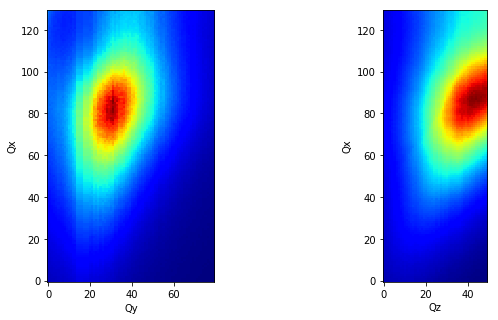

In [192]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(roi.sum(axis=2),origin='lower',cmap='jet')
ax1.set_ylabel('Qx');ax1.set_xlabel('Qy')
plt.axis('image')
ax2.imshow(roi.sum(axis=1),cmap='jet')
plt.ylabel('Qx');plt.xlabel('Qz')
plt.axis('image')
plt.show()

Seems like a good ROI. Try to make the projections and fit them:

In [295]:
import peakutils as pk

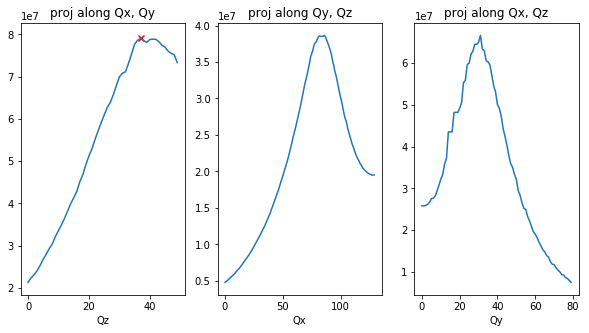

In [297]:
%matplotlib inline
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))

p2 = roi.sum(axis=0).sum(axis=0)
ax1.plot(p2) # proj. axis 2
p2_idx = pk.indexes(p2,thres=0.99, min_dist=10)
ax1.scatter(p2_idx, p2[p2_idx],marker='x',c='r')
ax1.set_title('proj along Qx, Qy')
ax1.set_xlabel('Qz')

p0 = roi.sum(axis=1).sum(axis=1)
ax2.plot(p0) # proj. axis 0
ax2.set_title('proj along Qy, Qz')
ax2.set_xlabel('Qx')

p1 = roi.sum(axis=0).sum(axis=1)
ax3.plot(p1) # proj. axis 1
ax3.set_title('proj along Qx, Qz')
ax3.set_xlabel('Qy')

plt.show()

Try to fit a Lorentzian to these peaks

In [337]:
def lorentzian(x,p):# fwhm, peak centre, intensity
    y = p[2]*(p[0]**2/((x-p[1])**2 + p[0]**2))
    return y

def residual(p,y,x):
    err = y - lorentzian(x,p)
    return err

In [338]:
from scipy.optimize import leastsq
from scipy.signal import savgol_filter

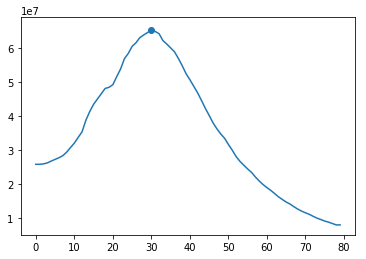

In [403]:
# p0
p0_smooth = savgol_filter(p1, 3, 0)
p0_peak = pk.indexes(p0_smooth, thres=0.99)
plt.plot(p0_smooth)
plt.scatter(p0_peak, p0_smooth[p0_peak]);

Init Lorentzian values:

In [404]:
p0_init = [50,p0_peak, p0_smooth[p0_peak]] # fwhm, peak centre, intensity

In [405]:
p0_optimised = leastsq(residual, p0_init,args=(p1,range(len(p1))))[0]

In [406]:
p0_fit = lorentzian(range(len(p1)),p1_optimised)

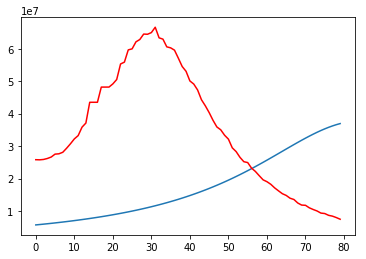

In [407]:
plt.plot(p0_fit)
plt.plot(p1,c='r')
plt.show()

This is what their eye estimation looks like. Not quite there -- the shape of the peak not being parallel to the q axes is making a difference.

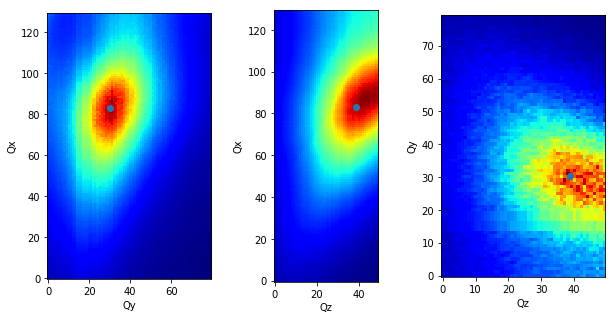

In [233]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))
ax1.imshow(roi.sum(axis=2),origin='lower',cmap='jet')
ax1.set_ylabel('Qx');ax1.set_xlabel('Qy')
# ax1.scatter(COM[1],COM[0],c='b')
ax1.scatter(30.3,83)
ax1.set_aspect('equal')

ax2.imshow(roi.sum(axis=1),origin='lower',cmap='jet')
ax2.set_ylabel('Qx');ax2.set_xlabel('Qz')
# ax2.scatter(COM[2],COM[0])
ax2.scatter(38.67,83)
ax2.set_aspect('equal')

ax3.imshow(roi.sum(axis=0),origin='lower',cmap='jet')
ax3.set_ylabel('Qy');ax3.set_xlabel('Qz')
# ax1.scatter(COM[1],COM[0],c='b')
ax3.set_aspect('equal')
ax3.scatter(38.67,30.3)
plt.show()

## Carsten's COM

Try with Carsten's method. Determine the indec `n` most intense pixels within the flattened roi array:

In [273]:
take = 1000
isort = roi.argsort(axis=None)[::-1][:take]
# isort

Find the corresponding intensity values:

In [274]:
roisort = roi.ravel()[isort] - roi.ravel()[isort].min()
# roisort

Calc the COM for the corresponding pixel values if the q meshes:

In [275]:
qCOM = [(arr[iroi].ravel()[isort]*roisort).sum() / roisort.sum() for arr in (qx,qy,qz)]

In [276]:
qxr = qx[iroi]
qyr = qy[iroi]
qzr = qz[iroi]

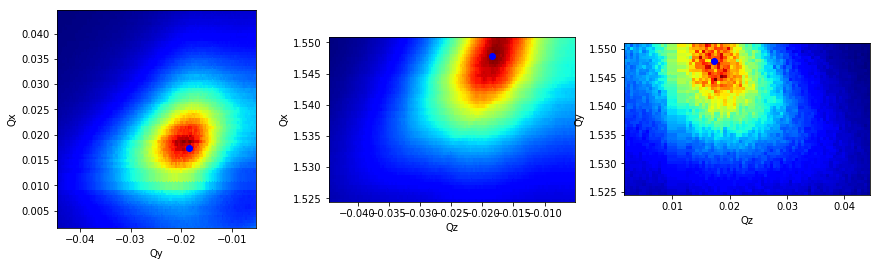

In [277]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))

ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],roi.sum(axis=2),cmap='jet')
ax1.set_ylabel('Qx');ax1.set_xlabel('Qy')
ax1.scatter(qCOM[0],qCOM[1],c='b')
ax1.set_aspect('equal')

ax2.pcolormesh(qxr[:,0,:],qzr[:,0,:],roi.sum(axis=1),cmap='jet')
ax2.set_ylabel('Qx');ax2.set_xlabel('Qz')
ax2.scatter(qCOM[0],qCOM[2],c='b')
ax2.set_aspect('equal')

ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],roi.sum(axis=0),cmap='jet')
ax3.set_ylabel('Qy');ax3.set_xlabel('Qz')
ax3.scatter(qCOM[1],qCOM[2],c='b')
ax3.set_aspect('equal')

plt.show()

### Radial

In [151]:
sdata = np.load('../stitched_data/42_45.npy')

In [146]:
qx, qy, qz = calc.qconvert_e16014('../data/hc3211.h5',slist[0])

Cen pix corrected by mpxz: 0.0; mpxy: 0.0
Offsets used: defaultdict(<class 'float'>, {'phi': 0.0, 'nu': 0.0, 'eta': 0.0, 'mu': 0.0, 'delta': 0.0, 'rhz': 0.0, 'rhx': 0.0, 'rhy': 0.0})


In [147]:
qabs = np.sqrt(qx**2 + qy**2 + qz**2)

In [156]:
for index in range(sdata.shape[0]):
    frame = sdata[index]
    frame = calc.hotmaxipix(frame)
    frame[frame == 0] = 1
    
roi = sdata[iroi]

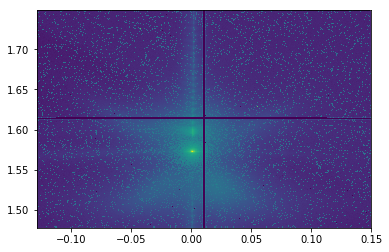

In [163]:
%matplotlib inline
plt.pcolormesh(qy[0],qz[0],np.log(sdata.sum(axis=0)))
plt.show()

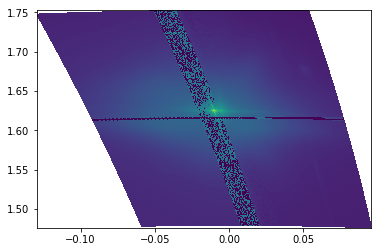

In [165]:
plt.pcolormesh(qx[:,:,0],qz[:,:,0],np.log(sdata.sum(axis=1)))
plt.show()

TypeError: Dimensions of C (130, 50) are incompatible with X (80) and/or Y (130); see help(pcolormesh)

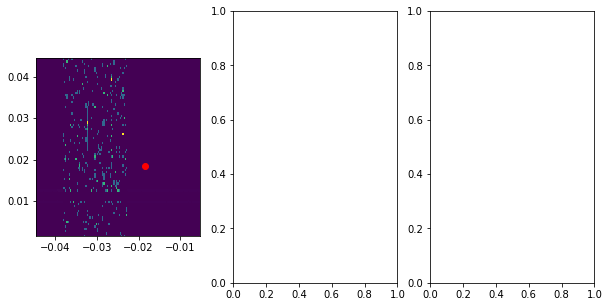

In [166]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))
ax1.pcolormesh(qxr[:,:,0],qyr[:,:,0],roi.sum(axis=2))
ax1.set_aspect('equal')
ax1.scatter(qxm,qym,c='r')
ax2.pcolormesh(qxr[:,:,0],qzr[:,:,0],roi.sum(axis=1))
ax2.set_aspect('equal')
ax3.pcolormesh(qyr[0,:,:],qzr[0,:,:],roi.sum(axis=0))
ax3.set_aspect('equal')

In [167]:
qabs.shape

(704, 516, 516)

In [128]:
qabs_com = (roi*qabs[iroi]).sum() / roi.sum()

In [129]:
take = 10000
isort = roi.argsort(axis=None)[::-1][:take]
roisort = roi.ravel()[isort] - roi.ravel()[isort].min()
qmax = (qabs[iroi].ravel()[isort]*roisort).sum() / roisort.sum() 

In [130]:
qmax, qabs_com

(1.5935171, 1.5935171)

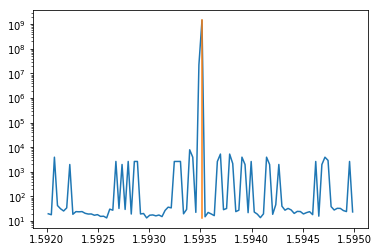

In [131]:
from id01lib.process import rebin
qrad, Irad = rebin.rebin1d(qabs[iroi], roi, bins=100, xmin=1.592, xmax=1.595)

plt.semilogy(qrad, Irad)
plt.semilogy([qmax]*2, [Irad.min(), Irad.max()])
#plt.xlim(1.593, 1.594)

### Other

In [34]:
isort = roi.argsort()[::-1]

In [39]:
isort[:11,:11,:11].shape

(11, 11, 11)

In [73]:
idx = (qx>0.1) * (qx<0.2)

Make the mesh of q-values:

In [19]:
roi=gint[280:410,240:320,90:140]

Calc the 001 c lattice param as well as its tilt

In [95]:
COM = ndimage.center_of_mass(roi)
print(COM)

(77.13129414046962, 32.737539175219332, 29.51991115791623)


In [70]:
roi.sum(axis=1).min()

36934.5

In [35]:
gint.sum(axis=2).min()

514.0

In [27]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

def detect_peaks(img):
    neighbourhood = generate_binary_structure(len(img.shape),2)
    local_max = maximum_filter(img, footprint=neighbourhood)==img
    background = (img==0)
    eroded_background = binary_erosion(background, structure=neighbourhood, border_value=1)
    detected_peaks = local_max ^ eroded_background
    return np.where(detected_peaks)

In [28]:
localmax = detect_peaks(roi)

In [63]:
qxp = qxr[:,0,0][int(COM[0])]
qyp = qxr[0,:,0][int(COM[1])]
qzp = qzr[0,0,:][int(COM[2])]
#qzp = 1.52\n",

q = np.sqrt(qxp**2+qyp**2+qzp**2)

_001 = (2*np.pi)/q
ang = np.rad2deg(np.arcsin((np.sqrt(qxp**2+qyp**2)/q)))

print(_001)
print((2*np.pi)/qzp)
print(ang)

NameError: name 'COM' is not defined